# Alpha and Beta Diversity Analysis: Coffee Consumption and Gut Microbiome

This notebook analyzes the relationship between coffee consumption patterns and gut microbiome diversity using comprehensive alpha and beta diversity metrics.

## Objectives:
- Calculate alpha diversity metrics across coffee consumption groups
- Perform beta diversity analysis to assess community structure differences
- Test statistical significance of diversity patterns
- Visualize diversity relationships with coffee consumption
- Establish baseline diversity patterns to inform differential abundance analysis

## Key Hypotheses:
1. **H1 (Primary)**: Coffee consumption is associated with specific bacterial taxa abundance 
2. **H2**: Daily coffee drinkers harbor distinct beneficial bacterial strains (ZOE-identified coffee-associated taxa)
3. **H3**: Coffee groups show similar alpha diversity but distinct beta diversity patterns due to specific taxa shifts
4. **H4**: Coffee's prebiotic effects support beneficial bacteria without necessarily increasing overall species richness

## Research Context:
Based on ZOE research findings, coffee consumption promotes specific beneficial bacterial strains rather than broad diversity changes. This analysis will:
- **Assess overall diversity as context** (alpha diversity likely unchanged between groups)
- **Identify microbiome signatures** through beta diversity clustering patterns
- **Establish baseline patterns** to inform differential abundance testing in next notebook
- **Look for compositional shifts** rather than richness/evenness changes

## Analysis Strategy:
This notebook provides the **diversity foundation** for identifying specific coffee-associated bacterial strains. We expect:
- **Similar alpha diversity** across coffee groups (no overall richness changes)
- **Distinct beta diversity clustering** (compositional differences due to specific taxa)
- **Statistical validation** of community structure differences
- **Clear setup** for differential abundance testing where coffee-specific bacterial strains will be identified

---

## Analysis Flow:

### 1. **Data Loading & Environment Setup**
- Load clean datasets from notebook 02
- Import microbiome analysis libraries (scikit-bio, etc.)
- Configure analysis parameters and visualization settings
- Validate data integrity and sample alignment

### 2. **Data Preprocessing for Diversity Analysis**
- **Sequencing depth assessment**: Evaluate need for rarefaction
- **Feature filtering**: Remove low-abundance/low-prevalence taxa
- **Normalization strategy**: Choose appropriate method for diversity metrics
- **Quality control**: Final sample/feature validation

### 3. **Alpha Diversity Analysis**
- **Metric calculation**: Shannon, Simpson, Observed Species, Chao1, Pielou's Evenness
- **Group comparisons**: Coffee consumption groups (none/occasional/daily)
- **Statistical testing**: ANOVA/Kruskal-Wallis with effect sizes
- **Visualizations**: Box plots showing (expected) similarity across groups

### 4. **Beta Diversity Analysis**
- **Distance metrics**: Bray-Curtis, Jaccard, Aitchison distances
- **PCoA ordination**: Visualize community structure clustering
- **PERMANOVA testing**: Statistical significance of group differences
- **Dispersion analysis**: Test for group variability differences

### 5. **Integration and Interpretation**
- **Diversity synthesis**: Combined alpha and beta diversity patterns
- **Coffee signature validation**: Evidence for distinct microbiome compositions
- **Effect size assessment**: Magnitude of compositional differences
- **Foundation for differential abundance**: Clear rationale for taxa-specific analysis

## Expected Outcomes:
- **Alpha diversity**: Similar richness/evenness across coffee groups (H3 support)
- **Beta diversity**: Significant clustering by coffee consumption (H1, H2 support)
- **Statistical validation**: PERMANOVA significance indicating compositional differences
- **Clear biological rationale**: For proceeding to differential abundance testing

This analysis establishes whether coffee consumption creates **distinct microbiome signatures** before identifying the **specific bacterial drivers** in differential abundance analysis.

### Conceptual Overview of Alpha/Beta Diversity

#### Understanding Alpha, Beta, and Gamma Diversity

**Alpha Diversity (α-diversity)**: Species diversity **within** a single sample/community
- **Definition**: The number and evenness of species in a local community
- **Formula**: Various metrics including:
  - **Shannon Index**: H' = -Σ(pi × ln(pi)) where pi = proportion of species i
  - **Simpson Index**: D = 1 - Σ(pi²) 
  - **Observed Species**: Simple count of unique species present
- **In our context**: Diversity within each individual's gut microbiome
- **Use case**: Compare microbiome richness/evenness between coffee consumption groups

**Beta Diversity (β-diversity)**: Species diversity **between** communities/samples
- **Definition**: The difference in species composition between communities
- **Formula**: β = γ/α (Whittaker's original) or distance-based metrics:
  - **Bray-Curtis**: Focuses on abundance differences
  - **Jaccard**: Focuses on presence/absence differences
  - **Aitchison**: Compositional distance for microbiome data
- **In our context**: How different are gut microbiomes between individuals?
- **Use case**: Test if coffee groups have distinct microbiome compositions

**Gamma Diversity (γ-diversity)**: **Total** species diversity across the entire landscape/study
- **Definition**: The total number of species across all communities combined
- **Formula**: γ = α + β (additive partitioning) or γ = α × β (multiplicative)
- **In our context**: Total microbial diversity across ALL study participants

**Why We Don't Use Gamma Diversity Here:**
1. **Research Question**: We're interested in **differences between coffee groups**, not overall study diversity
2. **Statistical Power**: Gamma diversity is a single number for the entire dataset - can't compare groups
3. **Biological Relevance**: Individual gut diversity (alpha) and between-person differences (beta) are more meaningful
4. **Hypothesis Testing**: Our hypotheses focus on group-level patterns, not total landscape diversity

**Analysis Strategy**: Use alpha diversity to test if coffee affects individual microbiome richness/evenness, and beta diversity to test if coffee creates distinct microbiome signatures between people.

### 1. Data Loading & Environment Setup

In [1]:
# Import data manipulation libraries
import polars as pl
import numpy as np
import pandas as pd
import pyarrow as pa

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical libraries
import scipy.stats as stats # for ANOVA, chi-square tests, effect size calculations
import skbio
from sklearn import preprocessing
from cohens_d import cohens_d as cohens_d_func

# Import utility libraries
from pathlib import Path
import warnings

# Set up visualization parameters
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Set default figure size
sns.set_palette("Set2")  # Set default color palette

# Configure display options
pl.Config.set_fmt_str_lengths(100)  # Limit string length in polars output
pl.Config.set_tbl_rows(10)  # Limit number of rows displayed in polars
np.set_printoptions(precision=3, suppress=True)  # Set numpy print options
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed inpandas
pd.set_option('display.max_colwidth', 100)  # Limit column width

# Print confirmation that libraries loaded successfully
print("All libraries imported and configured successfully!")

All libraries imported and configured successfully!


In [2]:
# Define file paths
data_dir = Path("../data/processed")
feature_table_path = data_dir / "feature_table_clean.tsv"
metadata_path = data_dir / "metadata_clean.tsv"
taxonomy_path = data_dir / "taxonomy_clean.tsv"

# print dataset paths 
print(f"Feature table path: {feature_table_path}")
print(f"Metadata path: {metadata_path}")
print(f"Taxonomy path: {taxonomy_path}")

# read in datasets with polars
feature_table = pl.read_csv(feature_table_path, separator="\t")
metadata = pl.read_csv(metadata_path, separator="\t")
taxonomy = pl.read_csv(taxonomy_path, separator="\t")

# print dataset shapes
print(f"\nFeature table shape: {feature_table.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"Taxonomy shape: {taxonomy.shape}")

# Check sample alignment between metadata and feature table
metadata_samples = set(metadata["#SampleID"].to_list())
feature_sample_cols = [col for col in feature_table.columns if col != feature_table.columns[0]]
feature_samples = set(feature_sample_cols)

print(f"\nSample alignment check:")
print(f"Samples in clean metadata: {len(metadata_samples)}")
print(f"Samples in feature table: {len(feature_samples)}")
print(f"Common samples: {len(metadata_samples.intersection(feature_samples))}")

# list columns in metadata
print(f"\nMetadata columns:")
print(metadata.columns)

# display coffee consumption group distribution
group_counts = metadata['coffee_consumption'].value_counts()
print("\nCoffee consumption group distribution:")
print(group_counts)

Feature table path: ../data/processed/feature_table_clean.tsv
Metadata path: ../data/processed/metadata_clean.tsv
Taxonomy path: ../data/processed/taxonomy_clean.tsv

Feature table shape: (500, 4982)
Metadata shape: (4981, 11)
Taxonomy shape: (500, 8)

Sample alignment check:
Samples in clean metadata: 4981
Samples in feature table: 4981
Common samples: 4981

Metadata columns:
['#SampleID', 'age', 'gender', 'country', 'sample_type', 'diet_type', 'coffee_consumption', 'antibiotics_past_year', 'bmi', 'age_zscore', 'bmi_zscore']

Coffee consumption group distribution:
shape: (3, 2)
┌────────────────────┬───────┐
│ coffee_consumption ┆ count │
│ ---                ┆ ---   │
│ str                ┆ u32   │
╞════════════════════╪═══════╡
│ none               ┆ 1621  │
│ occasional         ┆ 1682  │
│ daily              ┆ 1678  │
└────────────────────┴───────┘


### 2. Data Preprocessing

- **Sequencing depth assessment**: Evaluate need for rarefaction
- **Feature filtering**: Remove low-abundance/low-prevalence taxa
- **Normalization strategy**: Choose appropriate method for diversity metrics
- **Quality control**: Final sample/feature validation

In [3]:
feature_table.head()
feature_table.shape

(500, 4982)

In [ ]:
feature_table.sum()

#OTU ID,Sample_00000,Sample_00001,Sample_00002,Sample_00003,Sample_00004,Sample_00005,Sample_00006,Sample_00007,Sample_00008,Sample_00009,Sample_00010,Sample_00011,Sample_00012,Sample_00013,Sample_00014,Sample_00015,Sample_00016,Sample_00017,Sample_00018,Sample_00019,Sample_00020,Sample_00021,Sample_00022,Sample_00023,Sample_00024,Sample_00025,Sample_00026,Sample_00027,Sample_00028,Sample_00029,Sample_00031,Sample_00032,Sample_00033,Sample_00034,Sample_00035,Sample_00036,…,Sample_04963,Sample_04964,Sample_04965,Sample_04966,Sample_04967,Sample_04968,Sample_04969,Sample_04970,Sample_04971,Sample_04972,Sample_04973,Sample_04974,Sample_04975,Sample_04976,Sample_04977,Sample_04978,Sample_04979,Sample_04980,Sample_04981,Sample_04982,Sample_04983,Sample_04984,Sample_04985,Sample_04986,Sample_04987,Sample_04988,Sample_04989,Sample_04990,Sample_04991,Sample_04992,Sample_04993,Sample_04994,Sample_04995,Sample_04996,Sample_04997,Sample_04998,Sample_04999
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
null,2452,2597,2435,2369,2409,2471,2404,2464,2450,2495,2405,2452,2444,2569,2519,2454,2604,2549,2621,2473,2484,2431,2566,2512,2461,2665,2576,2611,2602,2530,2498,2559,2491,2587,2381,2458,…,2493,2488,2536,2542,2562,2472,2469,2442,2475,2485,2524,2583,2500,2487,2384,2458,2616,2482,2471,2685,2457,2482,2538,2369,2456,2454,2522,2517,2463,2704,2464,2455,2441,2540,2419,2445,2357


In [7]:
# create sequencing depth table 
sample_columns = [col for col in feature_table.columns if col != feature_table.columns[0]]

# calculate read depth by summing down each column (sample) in the feature table
read_depths = []

for col in sample_columns:
    total = feature_table[col].sum()
    read_depths.append({"#SAMPLEID": col, "read_depth": total})

# convert to pl df
read_depths_df = pl.DataFrame(read_depths)

# display read depth table
print("\nRead depth table (head):")
print(read_depths_df.head())





Read depth table (head):
shape: (5, 2)
┌──────────────┬────────────┐
│ #SAMPLEID    ┆ read_depth │
│ ---          ┆ ---        │
│ str          ┆ i64        │
╞══════════════╪════════════╡
│ Sample_00000 ┆ 2452       │
│ Sample_00001 ┆ 2597       │
│ Sample_00002 ┆ 2435       │
│ Sample_00003 ┆ 2369       │
│ Sample_00004 ┆ 2409       │
└──────────────┴────────────┘


In [8]:
# display summary statistics for read depth
print("\nRead depth summary statistics:")
print(read_depths_df["read_depth"].describe())  



Read depth summary statistics:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 4981.0      │
│ null_count ┆ 0.0         │
│ mean       ┆ 2501.336679 │
│ std        ┆ 70.385046   │
│ min        ┆ 2250.0      │
│ 25%        ┆ 2453.0      │
│ 50%        ┆ 2500.0      │
│ 75%        ┆ 2548.0      │
│ max        ┆ 2754.0      │
└────────────┴─────────────┘


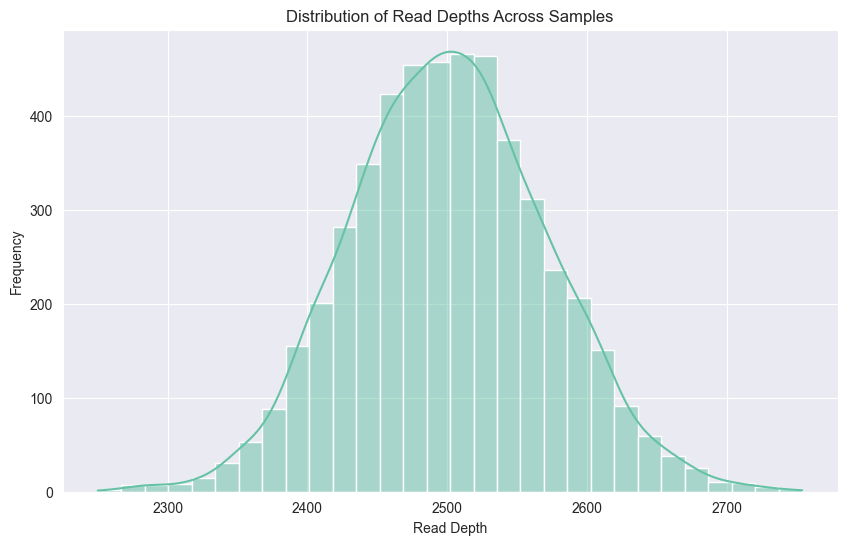

In [9]:
# plot a distribution of read depths
plt.figure(figsize=(10, 6))
sns.histplot(read_depths_df["read_depth"], bins=30, kde=True)
plt.title("Distribution of Read Depths Across Samples")
plt.xlabel("Read Depth")
plt.ylabel("Frequency")
plt.show()

#### Sequencing Depth Assessment Summary

**Key Observation**: Read depths vary across samples (range: ~2,300 - 2,700 reads per sample)

**Bias Concern**: 
- Samples with higher read depths (2,700) will appear to have higher alpha diversity
- Samples with lower read depths (2,300) may miss rare taxa, appearing less diverse
- This technical variation can create **false biological signals** in diversity comparisons

**Impact on Analysis**:
- Coffee consumption groups might appear to differ in diversity due to sequencing depth differences rather than true biological differences
- Statistical tests comparing alpha diversity between groups become unreliable
- Need normalization to ensure fair comparison across samples

**Next Steps**: Evaluate normalization strategies (rarefaction, relative abundance, or CSS normalization) before proceeding to alpha diversity calculations.